# Preliminaries

In [1]:
# General data and plotting
import json
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# Get Data

In [2]:
# get file
JsonFile = open('rideshare_user_history.json', 'r').read()  # reads text of file as string
JsonLoad = json.loads(JsonFile)  # converts string to parsed json

# convert list of dictionaries to pd.Dataframe
Df = pd.DataFrame(JsonLoad)

# checkpoint
DfOrig = Df

# Prepare Data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11570bfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e99dc10>]], dtype=object)

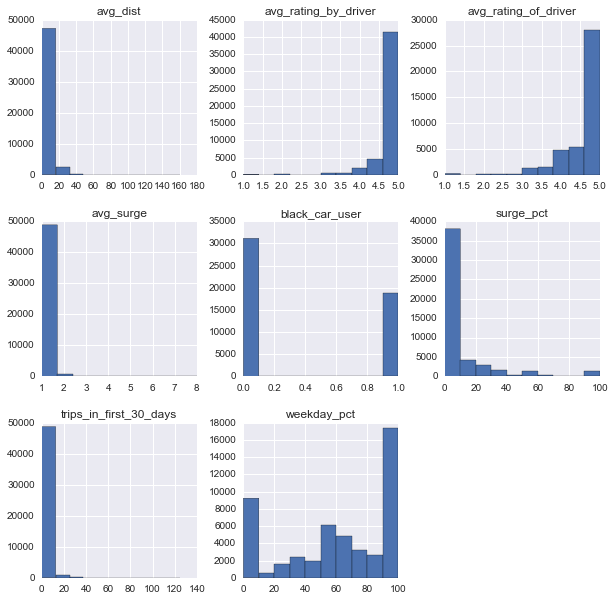

In [3]:
Df.hist(figsize=(10,10))

### convert types

In [4]:
# dates
Df['last_trip_date'] = pd.to_datetime(Df['last_trip_date'])
Df['signup_date'] = pd.to_datetime(Df['signup_date'])

# convert dates to numeric
date_diff = (Df['signup_date'] - Df['signup_date'].min())
Df['days_from_first_signup'] = date_diff.astype('timedelta64[D]')

# use date to create target
TimeCutoff = Df['last_trip_date'].max() - dt.timedelta(days=30)
Df['churn'] = np.where(Df['last_trip_date'] < TimeCutoff, 1, 0).astype(np.uint8)

# drop date fields
Df = Df.drop(['signup_date', 'last_trip_date'], axis=1)

# categorical
Df['city'] = Df['city'].astype('category')
Df['phone'] = Df['phone'].astype('category')

# boolean
Df['black_car_user'] = np.where(Df['black_car_user'] == True, 1, 0).astype(np.uint8)

# continuous (percents)
Df['weekday_pct'] = Df['weekday_pct'].astype('float')/100
Df['surge_pct'] = Df['surge_pct'].astype('float')/100
Df['trips_in_first_30_days'] = Df['trips_in_first_30_days'].astype(np.float)

# checkpoint
DfTypes = Df

### impute values

In [5]:
# rating of driver
ImpValArod = Df['avg_rating_of_driver'].median()
Df['avg_rating_of_driver'] = Df['avg_rating_of_driver'].fillna(ImpValArod)

# rating by driver
ImpValArbd = Df['avg_rating_by_driver'].median()
Df['avg_rating_by_driver'] = Df['avg_rating_by_driver'].fillna(ImpValArbd)

# phone
ImpValPhone = 'Other'
Col = Df['phone'].cat.add_categories(ImpValPhone)
Col = Col.fillna(ImpValPhone)
Df['phone'] = Col

# checkpoint
DfImputed = Df

### create dummies

In [6]:
# dummify category variables
# get_dummies() converts 'category fields' only
Df = pd.get_dummies(Df)

# drop the first dummy for each category
Df = Df.drop(["city_King's Landing", 'phone_iPhone'], axis=1)

# checkpoint
DfDummies1 = Df

# Feature Selection

### Anova

In [1477]:
from sklearn.feature_selection import f_classif, mutual_info_classif
X = Df.drop('churn', axis=1)
y = Df['churn']

# get anova results
fc = f_classif(X, y)
DfAnova = pd.DataFrame(np.vstack(fc).T, index=X.columns, columns=['F-Stat', 'p-value'])
print np.round(DfAnova.sort_values('F-Stat', ascending=False), 4)

                           F-Stat  p-value
phone_Android           2677.7169   0.0000
trips_in_first_30_days  2317.2939   0.0000
black_car_user          2193.3861   0.0000
city_Astapor            1573.1445   0.0000
avg_dist                 434.1249   0.0000
city_Winterfell          108.8594   0.0000
avg_rating_of_driver      84.5238   0.0000
avg_rating_by_driver      37.9718   0.0000
days_from_first_signup    20.4310   0.0000
surge_pct                  6.9589   0.0083
weekday_pct                4.6979   0.0302
phone_Other                2.7521   0.0971
avg_surge                  0.5555   0.4561


Least Significant: phone_other, weekday_pct, avg_rating_of_driver, surge_pct<br>
Most Significant: phone_android, trips, black car, city, avg_dist

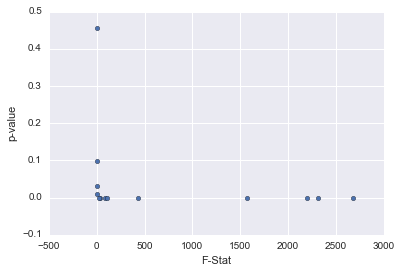

In [1478]:
DfAnova = pd.DataFrame(data=np.vstack(fc).T, columns=['F-Stat', 'p-value'])
DfAnova.plot(kind='scatter', x='F-Stat', y='p-value')

### Mutual Information

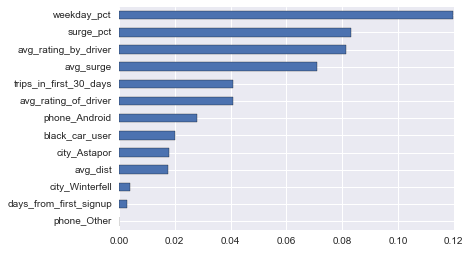

In [1479]:
# get mutual_info results
mc = mutual_info_classif(X, y)
pd.Series(data=mc, index=X.columns).sort_values().plot(kind='barh')

### Multi-collinearity

In [1480]:
# look at correlations within features
(np.round(Df.corr(), 4)*100).astype(np.int)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,black_car_user,surge_pct,trips_in_first_30_days,weekday_pct,days_from_first_signup,churn,city_Astapor,city_Winterfell,phone_Android,phone_Other
avg_dist,100,7,5,-8,3,-10,-13,10,1,9,-4,3,2,2
avg_rating_by_driver,7,100,10,1,0,2,-4,1,0,2,3,-9,0,0
avg_rating_of_driver,5,10,100,-1,0,0,-4,0,0,4,3,-8,3,0
avg_surge,-8,1,-1,100,-7,79,0,-11,0,0,3,-2,0,-1
black_car_user,3,0,0,-7,100,-10,11,3,0,-20,2,-5,-7,4
surge_pct,-10,2,0,79,-10,100,0,-14,0,-1,4,-6,-1,-1
trips_in_first_30_days,-13,-4,-4,0,11,0,100,5,1,-21,-6,3,-5,0
weekday_pct,10,1,0,-11,3,-14,5,100,0,0,-1,-1,0,1
days_from_first_signup,1,0,0,0,0,0,1,0,100,2,1,-3,1,0
churn,9,2,4,0,-20,-1,-21,0,2,100,17,4,22,0


           avg_surge  surge_pct  pca_surge
avg_surge     100.00      79.36      95.94
surge_pct      79.36     100.00      93.30
pca_surge      95.94      93.30     100.00


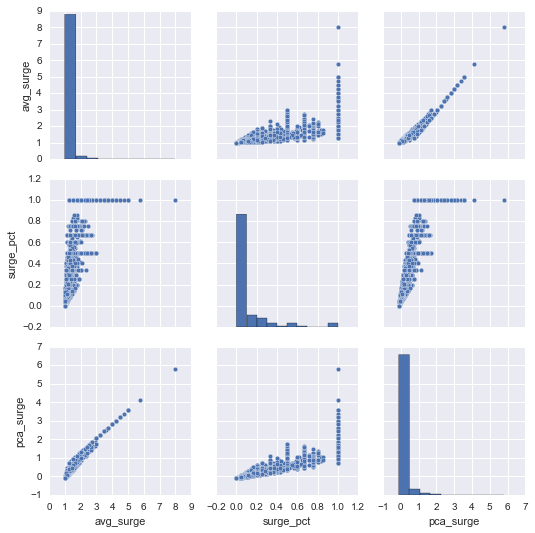

In [1481]:
from sklearn.decomposition import PCA

DfMc = pd.DataFrame()

# create new df for Mc columns
DfMc[['avg_surge', 'surge_pct']] = Df[['avg_surge', 'surge_pct']]

# get priciple component for avg_surge and surge_pct
pca = PCA(n_components=1)
DfMc['pca_surge'] = pca.fit_transform(DfMc.loc[:, ['avg_surge', 'surge_pct']])

# analyze ther variables relative to each other
print np.round(DfMc.corr(), 4)*100
sns.pairplot(DfMc)

In [1482]:
fc = f_classif(DfMc, y)

DfAnova = pd.DataFrame(np.vstack(fc).T, index=DfMc.columns, columns=['F-Stat', 'p-value'])
DfAnova = np.round(DfAnova, 4)
DfAnova

,F-Stat,p-value
avg_surge,0.5555,0.4561
surge_pct,6.9589,0.0083
pca_surge,0.6114,0.4343


In [1483]:
# keep surge_pct, don't use the PCA term
Df = Df.drop(['avg_surge'], axis=1)

# Create DataFrame

In [1563]:
# extract target
y = np.where(Df['churn'] == True, 1, 0)
X = Df.drop(['churn'], axis=1)
X['intercept'] = 1
features = X.columns

# Model Fitting

### Backward Stepwise Feature Selection

In [1564]:
import statsmodels.api as sm
logit = sm.Logit(y, X)
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.556683
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49987
Method:                           MLE   Df Model:                           12
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.1592
Time:                        02:38:27   Log-Likelihood:                -27834.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                   0.0359      0.002     17.282      0.000         0.032    

In [1565]:
# drop weekday_pct
logit = sm.Logit(y, X.drop(['weekday_pct'], axis=1))
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.556686
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49988
Method:                           MLE   Df Model:                           11
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.1592
Time:                        02:38:28   Log-Likelihood:                -27834.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                   0.0361      0.002     17.426      0.000         0.032    

In [1566]:
# drop weekday_pct and avg_rating_of_driver
X1 = X
logit = sm.Logit(y, X1.drop(['weekday_pct', 'avg_rating_of_driver'], axis=1))
result = logit.fit()
results_v1 = result.summary() # keep in back pocket
print results_v1

Optimization terminated successfully.
         Current function value: 0.557186
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49989
Method:                           MLE   Df Model:                           10
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.1585
Time:                        02:38:28   Log-Likelihood:                -27859.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                   0.0366      0.002     17.688      0.000         0.033    

In [1567]:
y_pred_1 = result.predict(X1.drop(['weekday_pct', 'avg_rating_of_driver'], axis=1))
print metrics.accuracy_score(y_true=y, y_pred=y_pred_1>0.5)
print metrics.f1_score(y_true=y, y_pred=y_pred_1>0.5)

0.71902
0.791282256986


### Regularized Model

In [1568]:
logit = sm.Logit(y, X, axis=1)
result = logit.fit_regularized(alpha=1/0.01, method='l1')
print result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.568597129477
            Iterations: 62
            Function evaluations: 66
            Gradient evaluations: 62
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49991
Method:                           MLE   Df Model:                            8
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.1553
Time:                        02:38:28   Log-Likelihood:                -27963.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------

city, phone, black_car, trips and avg_distance are the most significant features

# Model Interpretation

### odds ratio

In [1569]:
# selected model
logit = sm.Logit(y, X.drop(['weekday_pct', 'avg_rating_of_driver'], axis=1))
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.557186
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49989
Method:                           MLE   Df Model:                           10
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.1585
Time:                        02:38:30   Log-Likelihood:                -27859.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                   0.0366      0.002     17.688      0.000         0.033    

In [1570]:
np.exp(result.params)

avg_dist                  1.037248
avg_rating_by_driver      1.183256
black_car_user            0.419660
surge_pct                 0.789765
trips_in_first_30_days    0.886653
days_from_first_signup    1.006077
city_Astapor              5.576889
city_Winterfell           3.342737
phone_Android             2.968449
phone_Other               1.874607
intercept                 0.258541
dtype: float64

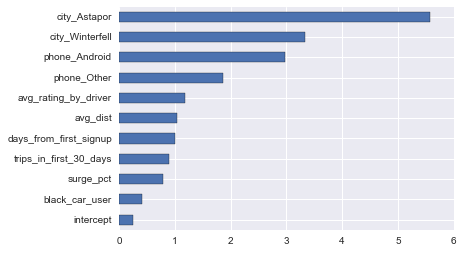

In [1571]:
# odds ratio
np.round(np.exp(result.params), 2).sort_values(ascending=True).plot(kind='barh')

In [1572]:
# odds ratio confidence intervals
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.round(np.exp(conf), 2).sort_values('OR', ascending=False)

                        2.5%  97.5%    OR
city_Astapor            5.26   5.91  5.58
city_Winterfell         3.17   3.52  3.34
phone_Android           2.83   3.12  2.97
phone_Other             1.49   2.35  1.87
avg_rating_by_driver    1.13   1.24  1.18
avg_dist                1.03   1.04  1.04
days_from_first_signup  1.00   1.01  1.01
trips_in_first_30_days  0.88   0.89  0.89
surge_pct               0.71   0.88  0.79
black_car_user          0.40   0.44  0.42
intercept               0.21   0.32  0.26


### prediction simulation

In [1526]:
# isolate features of interest from original df
sim_phone = DfTypes['phone'].unique()
sim_city = DfTypes['city'].unique()
sim_blackcar = DfTypes['black_car_user'].unique()
sim_trips = range(21) # based on sns.kdeplot(DfTypes['trips_in_first_30_days'])

In [1527]:
from itertools import combinations

# create simulated df
cartesian = itertools.product(*[sim_phone, sim_city, sim_blackcar, sim_trips])
cols = ['phone', 'city', 'black_car_user', 'trips_in_first_30_days']
DfSim = pd.DataFrame.from_records(list(cartesian), columns=cols)

# convert categories to dummies
DfSim = pd.get_dummies(DfSim)
DfSim = DfSim.drop(["city_King's Landing", 'phone_iPhone'], axis=1)

# fit model
X_fit = Df[DfSim.columns.tolist()]
X_fit['intercept'] = 1
logit = sm.Logit(y, X_fit)
result = logit.fit()
print result.summary()

# use model for predictions
X_sim = DfSim
X_sim['intercept'] = 1
y_pred_sim = result.predict(X_sim)

Optimization terminated successfully.
         Current function value: 0.562027
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49993
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.1512
Time:                        02:23:13   Log-Likelihood:                -28101.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
black_car_user            -0.8253      0.021    -39.342      0.000        -0.866    

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1528]:
# join predictions to simulated data
DfSimPlot = X_sim
DfSimPlot['y_pred'] = y_pred_sim

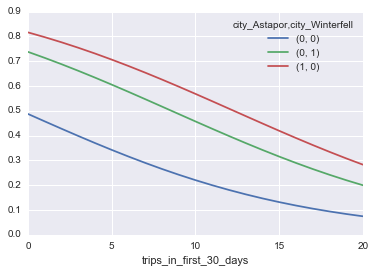

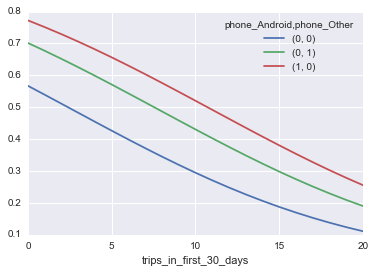

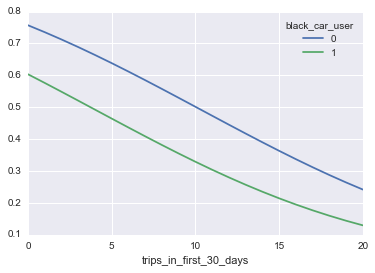

In [1529]:
# create 2d plots of categories against trips_in_first_30
for name in ['city', 'phone', 'black_car_user']:
    cols = [c for c in DfSimPlot.columns if name in c] + ['trips_in_first_30_days']
    DfPivot = pd.pivot_table(data=DfSimPlot, values='y_pred', columns=cols, aggfunc=np.mean)
    u_range = range(len(DfOrig[name].unique()) - 1)
    DfPivot.unstack(u_range).plot(kind='line')

# Appendix 1: Non-Linear Features

### Mutual Information

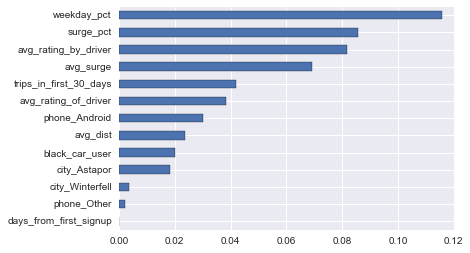

In [1573]:
# get mutual_info results
X_mc = DfDummies1.drop('churn', axis=1)
mc = mutual_info_classif(X_mc, y)

# print results
pd.Series(data=mc, index=X_mc.columns).sort_values().plot(kind='barh')

### Weekday Percent

In [1574]:
# updated model
cols = [c for c in X1.columns if 'weekday' in c]
fc = f_classif(X1[cols], y)

DfAnova = pd.DataFrame(np.vstack(fc).T, index=cols, columns=['F-Stat', 'p-value'])
print np.round(DfAnova.sort_values('F-Stat', ascending=False), 4)

             F-Stat  p-value
weekday_pct  4.6979   0.0302


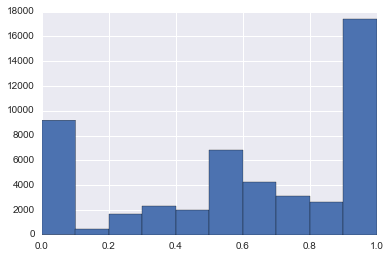

In [1575]:
X1['weekday_pct'].hist()

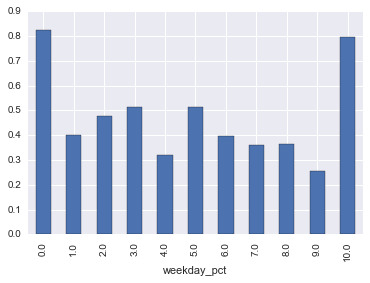

In [1576]:
X1_temp = X1.copy()
X1_temp['churn'] = y
X1_temp.groupby(np.floor(X1['weekday_pct']/0.1)).mean()['churn'].plot(kind='bar')

In [1577]:
X2 = X1.copy()

# create conversion function
def convert_weekday_pct(x):
    if x == 0:
        return 'weekends'
    elif x == 1:
        return 'weekdays'
    else:
        return 'mix'

# get dummies
X2['weekday_pct'] = X2['weekday_pct'].apply(convert_weekday_pct).astype('category')
X2 = pd.get_dummies(X2)
X2 = X2.drop('weekday_pct_mix', axis=1)

# fit model
logit = sm.Logit(y, X2.drop(['avg_rating_of_driver'], axis=1))
result = logit.fit()
results_v2 = result.summary() # keep in back pocket
print results_v2

Optimization terminated successfully.
         Current function value: 0.509513
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49987
Method:                           MLE   Df Model:                           12
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.2305
Time:                        02:38:52   Log-Likelihood:                -25476.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                   0.0186      0.002      8.424      0.000         0.014    

In [1579]:
# updated model
cols = [c for c in X2.columns if 'weekday' in c]
fc = f_classif(X2[cols], y)

DfAnova = pd.DataFrame(np.vstack(fc).T, index=cols, columns=['F-Stat', 'p-value'])
print np.round(DfAnova.sort_values('F-Stat', ascending=False), 4)

                         F-Stat  p-value
weekday_pct_weekdays  3340.8988      0.0
weekday_pct_weekends  2059.8616      0.0


In [1580]:
# fit
logit = sm.Logit(y, X2.drop(['avg_rating_of_driver'], axis=1))
result = logit.fit()
results_v2 = result.summary() # keep in back pocket
print results_v2

Optimization terminated successfully.
         Current function value: 0.509513
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49987
Method:                           MLE   Df Model:                           12
Date:                Tue, 20 Dec 2016   Pseudo R-squ.:                  0.2305
Time:                        02:39:01   Log-Likelihood:                -25476.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                   0.0186      0.002      8.424      0.000         0.014    

In [1581]:
y_pred_2 = result.predict(X2.drop(['avg_rating_of_driver'], axis=1))
print metrics.accuracy_score(y_true=y, y_pred=y_pred_2>0.5)
print metrics.f1_score(y_true=y, y_pred=y_pred_2>0.5)

0.75494
0.809276986536


# Appendix 2: Regularization

In [ ]:
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

### Full Model

In [ ]:
lrf = LogisticRegression(n_jobs=-1, penalty='l1', random_state=0, C=1000, fit_intercept=False) # 1000 = no penalty
lrf.fit(X, y)
pd.Series(lrf.coef_[0], index=features).plot(kind='barh')

In [ ]:
y_pred = cross_val_predict(estimator=lrf, X=X, y=y, cv=10)

In [ ]:
print "Accuracy Score: {0:.3f}".format(metrics.accuracy_score(y_pred=y_pred, y_true=y))
print "F1 Score: {0:.3f}".format(metrics.f1_score(y_pred=y_pred, y_true=y))
print "Classification Report: \n\n {0}".format(metrics.classification_report(y_pred=y_pred, y_true=y))

### L1 Regularization

In [ ]:
lr1 = LogisticRegression(n_jobs=-1, penalty='l1', random_state=0, C=0.001, fit_intercept=False)
lr1.fit(X, y)
pd.Series(lr1.coef_[0], index=features).plot(kind='barh')

In [ ]:
c_range = np.arange(-5, 2)
coef_list = {}
for n in c_range:
    lr = LogisticRegression(n_jobs=-1, penalty='l1', random_state=0, C=10**n)
    lr.fit(X, y)
    coef_list[10**n] = lr.coef_[0]

In [ ]:
df_coefs = pd.DataFrame.from_dict(coef_list)
df_coefs.index = features
df_coefs.T.plot(kind='line', figsize=(15, 8), logx=True)

In [ ]:
y_pred = cross_val_predict(estimator=lr1, X=X, y=y, cv=10)

In [ ]:
print "Accuracy Score: {0:.3f}".format(metrics.accuracy_score(y_pred=y_pred, y_true=y))
print "F1 Score: {0:.3f}".format(metrics.f1_score(y_pred=y_pred, y_true=y))
print "Classification Report: \n\n {0}".format(metrics.classification_report(y_pred=y_pred, y_true=y))

### L2 Regularization

In [ ]:
lr2 = LogisticRegression(n_jobs=-1, penalty='l2', random_state=0, C=0.001)
lr2.fit(X, y)
pd.Series(lr2.coef_[0], index=features).plot(kind='barh')

In [ ]:
c_range = np.arange(-5, 2)
coef_list = {}
for n in c_range:
    lr = LogisticRegression(n_jobs=-1, penalty='l2', random_state=0, C=10**n)
    lr.fit(X, y)
    coef_list[10**n] = lr.coef_[0]

In [ ]:
df_coefs = pd.DataFrame.from_dict(coef_list)
df_coefs.index = features
df_coefs.T.plot(kind='line', figsize=(15, 8), logx=True)

In [ ]:
y_pred = cross_val_predict(estimator=lr2, X=X, y=y, cv=10)

In [ ]:
print "Accuracy Score: {0:.3f}".format(metrics.accuracy_score(y, y_pred))
print 'F1 Score: {0:.3f}'.format(metrics.f1_score(y, y_pred))
print "Classification Report: \n\n {0}".format(metrics.classification_report(y_true=y, y_pred=y_pred))

# Appendix 3: Bias/Variance

### learning curves

In [ ]:
# tells you how accurate model becomes with more data
from sklearn.model_selection import learning_curve

# create cv estimates for range of train_sizes
train_sizes, train_scores, test_scores = \
    learning_curve(
        estimator=lr,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=10,
        n_jobs=1
        )

# get mean + sd, and plot
train_mean_lc = np.mean(train_scores, axis=1)
train_std_lc = np.std(train_scores, axis=1)
test_mean_lc = np.mean(test_scores, axis=1)
test_std_lc = np.std(test_scores, axis=1)

In [ ]:
train_mean = train_mean_lc; train_std = train_std_lc
test_mean = test_mean_lc; test_std = test_std_lc

# plot both curves
plt.figure(figsize=(8,5))  # graph size

plt.plot(train_sizes, train_mean,  # training data
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,  # training data ranges
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,  # test data
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,  # test data ranges
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# formatting
# plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()

### validation curve

In [ ]:
# addresses over/underfitting with different parameter estimates
from sklearn.model_selection import validation_curve

# Validation Curve: iterate through levels of a parameter to see impact on accuracy
#   Uses CV to get ranges of accuracy scores
c_range = np.arange(-5, 6)
param_range = [10**c for c in c_range]

# get cross validation scores
train_scores, test_scores = \
    validation_curve(estimator=lr,
                     X=X,
                     y=y,
                     param_name='C',
                     param_range=param_range,
                     cv=10)

# get mean + sd, and plot
train_mean_vc = np.mean(train_scores, axis=1)
train_std_vc = np.std(train_scores, axis=1)
test_mean_vc = np.mean(test_scores, axis=1)
test_std_vc = np.std(test_scores, axis=1)

In [ ]:
train_mean = train_mean_vc; train_std = train_std_vc
test_mean = test_mean_vc; test_std = test_std_vc

# plot both curves
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.xscale('log')
plt.xlabel('Regularization')
plt.ylabel('Accuracy')
plt.ylim(.71, .72)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### counter-example

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

mlp = MLPClassifier(activation='logistic')

# get rf accuracy with out of box settings
y_pred_mlp = cross_val_predict(estimator=mlp, X=X, y=y, cv=10)

In [ ]:
# Accuracy, AUC, Precision, Recall, F1
print 'Key Metrics \n******************'
print 'Accuracy: %.3f' % metrics.accuracy_score(y_true=y, y_pred=y_pred_mlp)
print 'F1 Score: %.3f' % metrics.f1_score(y_true=y, y_pred=y_pred_mlp)
print 'Classification Report: \n\n {0}'.format(metrics.classification_report(y, y_pred_mlp))

# Appendix 4: Feature Impact Analysis

In [1583]:
# create iterable data set
X = X2

# create performance measurement df
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics
import itertools

num_cols = 7
# Cols: 1, Rows: 10
# Cols: 2, Rows: 45
# Cols: 3, Rows: 120
# Cols: 4, Rows: 210
# Cols: 5, Rows: 252
# Cols: 6, Rows: 210
# Cols: 7, Rows: 120
# Cols: 8, Rows: 45
# Cols: 9, Rows: 10
# Cols: 10, Rows: 1

lr = LogisticRegression(n_jobs=-1, random_state=0, C=1000)
DfPerformance = pd.DataFrame(columns=X.columns.tolist() + ['n_features', 'accuracy', 'f1'])
feature_range = np.arange(10, 13, 1)

for n_features in feature_range:
    for i in itertools.combinations(X.columns, n_features):

        # subset df
        subset_cols = list(i) # convert to list
        X_sub = pd.get_dummies(X[subset_cols], drop_first=True) # create subset df

        # make predictions
        y_pred = cross_val_predict(estimator=lr, X=X_sub, y=y, cv=5)

        # get accuracy and f1 scores
        accuracy_sub = metrics.accuracy_score(y_true=y, y_pred=y_pred)
        f1_sub = metrics.f1_score(y_true=y, y_pred=y_pred)

        # create series of features and scores
        new_features = pd.Series.from_array(subset_cols).value_counts()
        new_scores = pd.Series([n_features, accuracy_sub, f1_sub], ['n_features', 'accuracy', 'f1'])
        new_series = new_features.append(new_scores)

        # append to dataframe
        DfPerformance = DfPerformance.append(new_series, ignore_index=True)

# fill na
DfPerformance = DfPerformance.fillna(0)

# check values
DfPerformance.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,black_car_user,surge_pct,trips_in_first_30_days,days_from_first_signup,city_Astapor,city_Winterfell,phone_Android,phone_Other,intercept,weekday_pct_weekdays,weekday_pct_weekends,n_features,accuracy,f1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,10.0,0.71872,0.791149
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,10.0,0.70452,0.785287
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,10.0,0.70440,0.785243
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,10.0,0.71702,0.788982
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,10.0,0.71398,0.788850


In [1584]:
X_feature_combinations = DfPerformance.drop(['n_features', 'accuracy', 'f1'], axis=1)
X_feature_combinations['intercept'] = 1
y_accuracy = DfPerformance['accuracy']
y_f1 = DfPerformance['f1']

In [1585]:
# accuracy
import statsmodels.api as sm

mod = sm.OLS(endog=y_accuracy, exog=X_feature_combinations)
res_acc = mod.fit()
print res_acc.summary()

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     825.8
Date:                Tue, 20 Dec 2016   Prob (F-statistic):               0.00
Time:                        04:21:26   Log-Likelihood:                 5217.5
No. Observations:                1456   AIC:                        -1.041e+04
Df Residuals:                    1442   BIC:                        -1.033e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                   0

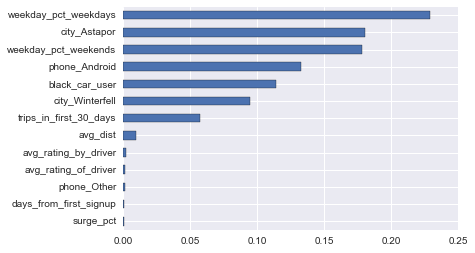

In [1586]:
abs_weights_accuracy = abs(res_acc.params.drop('intercept'))
freq_accuracy = (abs_weights_accuracy/abs_weights_accuracy.sum())
freq_accuracy.sort_values().plot(kind='barh')

In [291]:
# f1
import statsmodels.api as sm

mod = sm.OLS(endog=y_f1, exog=X_feature_combinations)
res_f1 = mod.fit()
print res_f1.summary()

                            OLS Regression Results                            
Dep. Variable:                     f1   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     225.7
Date:                Sat, 17 Dec 2016   Prob (F-statistic):          1.28e-249
Time:                        18:37:27   Log-Likelihood:                 3648.1
No. Observations:                1023   AIC:                            -7274.
Df Residuals:                    1012   BIC:                            -7220.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
avg_dist                1.29

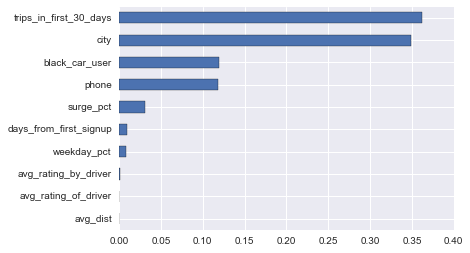

In [300]:
abs_weights_f1 = abs(res_f1.params.drop('intercept'))
freq_f1 = (abs_weights_f1/abs_weights_f1.sum())
freq_f1.sort_values().plot(kind='barh')